# Interpretable Log Contrasts for the Classification of Health Biomarkers: a New Approach to Balance Selection
![](https://f1000researchdata.s3.amazonaws.com/manuscripts/17311/e0117dfa-3e5f-45c3-a142-444d7099ff96_figure1.gif)


In [1]:
suppressWarnings(suppressMessages(library(balance)))
suppressWarnings(suppressMessages(library(zCompositions)))
library(tidyverse)
library(ggpubr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.4
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::select() masks MASS::select()


## rewrite the distalDBA function for pretty plots

In [ ]:
pound2inch = 1/72
Linesp=1.5

sbp.subset <- function (sbp, ternary = TRUE, ratios = TRUE){
    if (!ternary & !ratios) {
        message("Alert: Skipping balance subset.")
        return(sbp)
    }
    if (ternary & !ratios) {
        message("Alert: Using 'ternary' enables 'ratios' too.")
        ratios <- TRUE
    }
    b.size <- apply(sbp, 2, function(x) sum(abs(x)))
    keep <- rep(FALSE, ncol(sbp))

                    keep <- keep | (b.size == 3)
    if (ratios) 
        keep <- keep | (b.size == 2)
    sbp <- sbp[, keep, drop = FALSE]
    joinNames <- function(bp, x) make.names( 
        paste0(
        c(paste0(x[bp==1],collapse = "_"), #分子 
          paste0(x[bp==-1], collapse = "_")),  #分母
        collapse="__") #分子__分母1_分母2 or 分子1_分子2__分母
    ) 
    colnames(sbp) <- apply(sbp, 2, function(x) joinNames(x[x !=0], rownames(sbp)[x !=0]))
    sbp
}  
                           
balance_plot_yang <- function (x, y, d.group, n.group, 
                               boxplot.split = TRUE, weigh.var = FALSE, 
                               size.text = 20, size.pt = 4){
    Amber=c('#ff5b47', '#8cfd94','#ffd700', '#ffa001','#8aceea', '#d4a1d1','#fd6ab3','#9775de',
        '#b9c206','#f5b5c9','#a3fe41','#ddb689','#437bb4','#dd6b28','#47d8c3','#c56dc5')
    cols <- Amber
    if (ncol(x) != nrow(y)) {
        stop("Please check that ncol(x) = nrow(y) = D.")
    }
    if (any(x == 0)) {
        stop("Please remove zeros before analysis.")
    }
    if (is.null(colnames(x))) {
        colnames(x) <- paste0("Component", 1:ncol(x))
    }
    if (is.null(colnames(y))) {
        colnames(y) <- paste0("Balance", 1:ncol(y))
    }
    if (is.null(rownames(x))) {
        rownames(x) <- as.character(1:nrow(x))
    }
    x <- as.data.frame(x)
    y <- as.data.frame(y)
    rownames(y) <- colnames(x)
    b.weight <- apply(y, 2, function(i) sum(abs(i)))
    b.order <- order(b.weight, decreasing = TRUE)
    d.weight <- apply(y[, b.order], 1, function(i) sum(i * 1/1:length(i)))
    d.order <- order(d.weight, decreasing = TRUE)
    pt <- y
    pt <- wide2long(pt)
    pt <- pt[pt$value != 0, ]
    colnames(pt) <- c("Part", "BalanceID", "Component")
    pt$Component <- factor(pt$Component, colnames(x)[d.order])
    pt$BalanceID <- factor(pt$BalanceID, rev(colnames(y)[b.order]))
    pt$Part <- factor(pt$Part, levels = c(1, -1))
    pt$Group <- paste0(pt$BalanceID, pt$Part)
    B <- balance.fromSBP(x, y)
    colnames(B) <- colnames(y)
    rownames(B) <- rownames(x)
    dt <- wide2long(B)
    colnames(dt) <- c("SampleValue", "BalanceID", "Index")
    dt$BalanceID <- factor(dt$BalanceID, rev(colnames(y)[b.order]))
    if (weigh.var) {
        vars <- apply(B, 2, stats::var)
        vars <- vars/sum(vars)
        linewidth <- data.frame(BalanceID = colnames(B), LineWidth = vars)
        dt <- merge(dt, linewidth)
    }
    if (!all(pt$BalanceID %in% dt$BalanceID)) 
        stop("Unexpected Error: try renaming balances.")
    if (!all(dt$BalanceID %in% pt$BalanceID)) 
        stop("Unexpected Error: try renaming balances.")
    if (!missing(d.group)) {
        if (length(unique(d.group)) > 16) 
            stop("Only 16 groups for 'd.group' supported.")
        d.group <- as.character(d.group)
        names(d.group) <- colnames(x)
        pt$d.group <- d.group[as.character(pt$Component)]
        d.cols <- cols[1:length(unique(pt$d.group))]
    }
    else {
        pt$d.group <- "1"
        d.cols <- "black"
    }
    if (!missing(n.group)) {
        if (length(unique(n.group)) > 8) 
            stop("Only 8 groups for 'n.group' supported.")
        n.group <- as.character(n.group)
        names(n.group) <- rownames(x)
        dt$n.group <- n.group[as.character(dt$Index)]
        n.cols <- cols[1:length(unique(dt$n.group))]
    }
    else {
        dt$n.group <- "1"
        n.cols <- "black"
    }
    if (boxplot.split) {
        dt$Group <- paste(dt$BalanceID, dt$n.group)
    }
    else {
        dt$Group <- dt$BalanceID
    }
    balance.partition <- ggplot2::ggplot(pt, ggplot2::aes_string(x = "BalanceID", 
        y = "Component", shape = "Part", group = "Group")) + 
        ggplot2::geom_line() + ggplot2::geom_point(ggplot2::aes_string(col = "d.group"), 
        size = size.pt) + ggplot2::scale_colour_manual(values = d.cols) + 
        ggplot2::xlab("Balance ID") + ggplot2::ylab("Component ID") + 
        ggplot2::labs(col = "Component Group", shape = "Partition") + 
        ggplot2::coord_flip() + ggplot2::theme_bw() + ggplot2::theme(axis.text.x = ggplot2::element_text(angle = 90, 
        hjust = 1, vjust = 0.5)) + ggplot2::theme(text = ggplot2::element_text(size = size.text)) + 
        ggplot2::theme(legend.position = "top")
    balance.distribution <- ggplot2::ggplot(dt, ggplot2::aes_string(x = "BalanceID", 
        y = "SampleValue", group = "BalanceID"), col = "black") + 
        ggplot2::scale_colour_manual(values = n.cols) + ggplot2::xlab("") + 
        ggplot2::ylab("Sample-wise Distribution of Balance") + 
        ggplot2::ylim(-1.1 * max(abs(dt$SampleValue)), 1.1 * 
            max(abs(dt$SampleValue))) + ggplot2::labs(col = "Sample Group") + 
        ggplot2::coord_flip() + ggplot2::theme_bw() + ggplot2::theme(axis.text.x = ggplot2::element_text(angle = 90, 
        hjust = 1, vjust = 0.5)) + ggplot2::theme(text = ggplot2::element_text(size = size.text)) + 
        ggplot2::theme(legend.position = "top")
    if (weigh.var) {
        balance.distribution <- balance.distribution + ggplot2::geom_line(ggplot2::aes_string(size = "LineWidth"), 
            alpha = 0.5) + ggplot2::guides(size = FALSE)
    }
    else {
        balance.distribution <- balance.distribution + ggplot2::geom_line(alpha = 0.5) + 
            ggplot2::guides(size = FALSE)
    }
    if (boxplot.split) {
        balance.distribution <- balance.distribution + ggplot2::geom_boxplot(ggplot2::aes_string(group = "Group", 
            col = "n.group"), outlier.size = size.pt/2, position = ggplot2::position_dodge(0.8), 
            alpha = 0.5)
    }
    else {
        balance.distribution <- balance.distribution + ggplot2::geom_point(ggplot2::aes_string(col = "n.group"), 
            size = size.pt/2, position = ggplot2::position_dodge(0.8), 
            alpha = 0.5)
    }
    grid::grid.newpage()
    grob <- cbind(ggplot2::ggplotGrob(balance.partition), ggplot2::ggplotGrob(balance.distribution), 
        size = "first")
    grid::grid.draw(grob)
    res <- methods::new("bplot")
    res@balance.partition <- balance.partition
    res@balance.distribution <- balance.distribution
    return(res)
}                         

                        

distal_DBA <- function(otu_file, sample_file, tax_file,
                       phynotype="Disease.MESH.ID", 
                       tax_level  = 'Phylum', # Domain  Phylum  Class   Order   Family  Genus   Species 
                       limitsize = FALSE, #for ggsave
                       sep="\t"){
    
    otu_table <- read.table(otu_file, header=T, row.names=1,sep=sep) %>% t()    
    sample_data_withIndex <- read.table(sample_file, header=T, row.names=1,comment.char='', sep=sep) %>%
                   .[eval(phynotype)] 
    sample_data <- sample_data_withIndex[,eval(phynotype)]
    tax_group <- read.table(tax_file, header=T, row.names=1,comment.char='', sep=sep) %>%
                   .[, eval(tax_level)] 
    write.csv(sample_data_withIndex,file=paste0(sample_file,'.diseaseId.csv'))
    
                    
    dl <- rep(0.0001, ncol(otu_table)) 
    #Numeric vector or matrix of detection limits/thresholds 0被替换为小于dl的值
    if (any(otu_table==0)) {
        otu_table <- multRepl(otu_table, label=0, dl=dl, closure=100) 
        #closure=10^6 if ppm or closure=100 if percentages
        # imp.missing = TRUE 会把0当成缺失值，补充为可能较大的值
    }

    sbp <- sbp.fromADBA(otu_table, sample_data) #all balances
    sbp <- sbp.subset(sbp) # subset D-2,D-3 part balances  
    #分子__分母1_分母2 or 分子1_分子2__分母
    #输出sbp矩阵要保存下来，用于物种相对丰度的balance特征提取（balance.fromSBP），
    # 然后用模型的最优特征集进行预测（z特征取一部分z）。
    colnames(sbp)<-str_replace(colnames(sbp),'^X','') #去掉数字前面的X
    write.csv(sbp,file=paste0(otu_file,'.balance.sbp.csv')) 
    
    # 可视化balance
    balance_plot <- balance_plot_yang(otu_table, sbp, 
                                 d.group=tax_group, n.group=sample_data, 
                                 boxplot.split = TRUE,
                                 weigh.var = TRUE, size.text = 10, size.pt = 2
                                )
    
    save(balance_plot, file = paste0(otu_file,'.balance_plot.RData'))
    balance_ggar <- ggarrange(balance_plot@balance.partition + 
                              rremove("x.text") + rremove("x.ticks") +
                              theme(legend.direction ="vertical",legend.position = "top") + #horizontal
                              guides(col = guide_legend(ncol = 2, byrow = F,keywidth =0., keyheight = 0.6)),
                              
                              balance_plot@balance.distribution + rremove("y.text")+
                              theme(legend.direction ="vertical",legend.position = "top") +
                              guides(col = guide_legend(reverse = T)), 
                              
                              nrow = 1, align = "h",
                              widths = c(5, 2)
                             )
    
    lt10 <- 10*pound2inch*Linesp*dim(sbp)[2]
    height <- ifelse(lt10>10, lt10, 10)
    ggsave(plot=balance_ggar, filename=paste0(otu_file,'.balance.partition_distribution.svg'), 
           width = 10, height = height, units = "in", limitsize = limitsize)
    ggsave(plot=balance_ggar, filename=paste0(otu_file,'.balance.partition_distribution.pdf'), 
           width = 10, height = height, units = "in", limitsize = limitsize)
    
    write.csv(balance_plot@balance.partition$data, file=paste0(otu_file,'.balance.partition.csv'))
    write.csv(balance_plot@balance.distribution$data, file=paste0(otu_file,'.balance.distribution.csv'))

    z <- balance.fromSBP( #Compute Balances from an SBP Matrix
        x = otu_table,
        y = sbp
    )
    rownames(z) <- rownames(sample_data_withIndex)# for sklearn logistic regression
    write.csv(z,file=paste0(otu_file,'.balance.csv')) 
    
    rownames(z) <- sample_data #for weka transform
    write.csv(z,file=paste0(otu_file,'.balance.weka.csv')) 
    return(balance_plot)
}

## run distal_DBA to get balance tables and balance plots

In [ ]:
# pwalk
run <- function(...) { 
    args <- tibble(...)
    paths <- map(args, as.character)
    print(paths$V1) #column name
    distal_DBA(paths$V1, paths$V2, paths$V3) #otu_table, sample_data, tax_table
}

#做一个table来存储otu_file, sample_file, tax_file,
balance_paths <- read.table("./balance_files.xls",header = F,sep='\t') 
balance_paths %>%
    pwalk(run) #walk 执行，无需返回

In [ ]:
tail(balance_paths )

## test ggdensity plots for top20 balances

In [ ]:
i='D065626'
wd = './metagenome/diseases_balance_species/'
lrg <- paste0(wd, i, "/otu_table.xls.balance.csv.LogisticRegression.hypertuned.coef.newids.csv")
blc <- paste0(wd, i, "/otu_table.xls.balance.distribution.csv")

lr <- read.table(lrg, header=T, row.names=NULL,sep=',')  
colnames(lr)[1] <- 'BalanceID'

bl <- read.table(blc, header=T, row.names=1,comment.char='', sep=',')
#F8766D red
uniq_group <- unique(bl$n.group)
if (as.vector(uniq_group[uniq_group!='D006262'])  < 'D006262'){ 
    palette <- c("#F8766D", "#00BFC4")
}else{
    palette <-  c("#00BFC4", "#F8766D")
}

lr[order(-abs(lr[,2])),][1:20,] %>% 
    inner_join(bl, by = "BalanceID") -> dt


p<- ggdensity(dt, 
          x = "SampleValue",
          rug = T, ncol=2,
          color = "n.group", fill = "n.group",
          palette = palette,
          facet.by = "BalanceID",  
          ylab="Density",
          xlab = "Balance Value",
          scales = "free_y",              
          short.panel.labs = T,) +
          scale_y_continuous(breaks = scales::pretty_breaks(n = 2)) +
          theme(axis.text.y = element_text(size=8)) 
p

## density plot for all diseases

In [ ]:
alist = "./amplicon/diseases_balance_species/amplicon_balance54.list"
mlist = './metagenome/diseases_balance_species/metagenome_balance37.list'

wd = './metagenome/diseases_balance_species/'

ml <- read.table(mlist, header=F,comment.char='', sep=',')
for (i in as.vector(ml$V1)) {
    lrg <- paste0(wd, i, "/otu_table.xls.balance.csv.LogisticRegression.hypertuned.coef.newids.csv")
    blc <- paste0(wd, i, "/otu_table.xls.balance.distribution.csv")

    lr <- read.table(lrg, header=T, row.names=NULL,sep=',')  
    colnames(lr)[1] <- 'BalanceID'
    
    bl <- read.table(blc, header=T, row.names=1,comment.char='', sep=',')
    # ascII码小的先出，先分配颜色，小的给红色
    uniq_group <- unique(bl$n.group)
    if (as.vector(uniq_group[uniq_group!='D006262'])  < 'D006262'){ 
        palette <- c("#F8766D", "#00BFC4")
    }else{
        palette <-  c("#00BFC4", "#F8766D")
    }

    lr[order(-abs(lr[,2])),][1:20,] %>% 
        inner_join(bl, by = "BalanceID") -> dt

  
    p<- ggdensity(dt, 
              x = "SampleValue",
              rug = T, ncol=2,
              color = "n.group", fill = "n.group",
              palette = palette,
              facet.by = "BalanceID",  
              ylab="Density",
              xlab = "Balance Value",
              scales = "free_y",              
              short.panel.labs = T,) +
              scale_y_continuous(breaks = scales::pretty_breaks(n = 2)) +
              theme(axis.text.y = element_text(size=8))

    ggsave(plot=p, filename=paste0(str_sub(blc, 1,-4),'top20.svg'),
           height = 10, units = "in",limitsize = FALSE) 
  
}

wd = './amplicon/diseases_balance_species/'
al <- read.table(alist, header=F,comment.char='', sep=',')
for (i in as.vector(al$V1)) {
    lrg <- paste0(wd, i, "/otu_table.xls.balance.csv.LogisticRegression.hypertuned.coef.newids.csv")
    blc <- paste0(wd, i, "/otu_table.xls.balance.distribution.csv")

    lr <- read.table(lrg, header=T, row.names=NULL,sep=',')  
    colnames(lr)[1] <- 'BalanceID'
    
    bl <- read.table(blc, header=T, row.names=1,comment.char='', sep=',')
    uniq_group <- unique(bl$n.group)
    if (as.vector(uniq_group[uniq_group!='D006262'])  < 'D006262'){ 
        palette <- c("#F8766D", "#00BFC4")
    }else{
        palette <-  c("#00BFC4", "#F8766D")
    }
    
    lr[order(-abs(lr[,2])),][1:20,] %>% 
        inner_join(bl, by = "BalanceID") -> dt

  
    p<- ggdensity(dt, 
              x = "SampleValue",
              rug = T, ncol=2,
              color = "n.group", fill = "n.group",
              palette = palette,
              facet.by = "BalanceID",  
              ylab="Density",
              xlab = "Balance Value",
              scales = "free_y",              
              short.panel.labs = T,) +
              scale_y_continuous(breaks = scales::pretty_breaks(n = 2)) +
              theme(axis.text.y = element_text(size=8))

    ggsave(plot=p, filename=paste0(str_sub(blc, 1,-4),'top20.svg'),
           height = 10, units = "in",limitsize = FALSE) 
  
}

# top20 balances 在各个疾病中的overlap情况.

In [ ]:
alist = "./amplicon/diseases_balance_species/amplicon_balance54.list"
mlist = './metagenome/diseases_balance_species/metagenome_balance37.list'

wd = './metagenome/diseases_balance_species/'
ml <- read.table(mlist, header=F,comment.char='', sep=',')

library(tidyverse)
metagenome_37D_top20Balance <- data.frame()

for (i in as.vector(ml$V1)) {
    lrg <- paste0(wd, i, "/otu_table.xls.balance.csv.LogisticRegression.hypertuned.coef.newids.csv")
    lr <- read.table(lrg, header=T, row.names=NULL,sep=',')  
    colnames(lr)[1] <- 'Top20BalanceID'
    lr[order(-abs(lr[,2])),][1:20,] -> dt
    dt %>% gather("Diseases", "LRcoef", -Top20BalanceID) ->topi
    metagenome_37D_top20Balance <- metagenome_37D_top20Balance %>% bind_rows(topi) # 合并所有疾病的top20 table
}


metagenome_37D_top20Balance  %>% 
    write.csv('metagenome_37D_top20Balance.csv',row.names = F)

In [ ]:
al <- read.table(alist, header=F,comment.char='', sep=',')
wd = './amplicon/diseases_balance_species/'
metagenome_37D_top20Balance <- data.frame()

for (i in as.vector(al$V1)) {
    lrg <- paste0(wd, i, "/otu_table.xls.balance.csv.LogisticRegression.hypertuned.coef.newids.csv")
    lr <- read.table(lrg, header=T, row.names=NULL,sep=',')  
    colnames(lr)[1] <- 'Top20BalanceID'
    lr[order(-abs(lr[,2])),][1:20,] -> dt
    dt %>% gather("Diseases", "LRcoef", -Top20BalanceID) ->topi
    metagenome_37D_top20Balance <- metagenome_37D_top20Balance %>% bind_rows(topi) # 合并所有疾病的top20 table
}


metagenome_37D_top20Balance  %>% 
    write.csv('amplicon_54D_top20Balance.csv',row.names = F)


metagenome_37D_top10Balance <- data.frame()

for (i in as.vector(al$V1)) {
    lrg <- paste0(wd, i, "/otu_table.xls.balance.csv.LogisticRegression.hypertuned.coef.newids.csv")
    lr <- read.table(lrg, header=T, row.names=NULL,sep=',')  
    colnames(lr)[1] <- 'Top10BalanceID'
    lr[order(-abs(lr[,2])),][1:10,] -> dt
    dt %>% gather("Diseases", "LRcoef", -Top10BalanceID) ->topi
    metagenome_37D_top10Balance <- metagenome_37D_top10Balance %>% bind_rows(topi) # 合并所有疾病的top20 table
}


metagenome_37D_top10Balance  %>% 
    write.csv('amplicon_54D_top10Balance.csv',row.names = F)

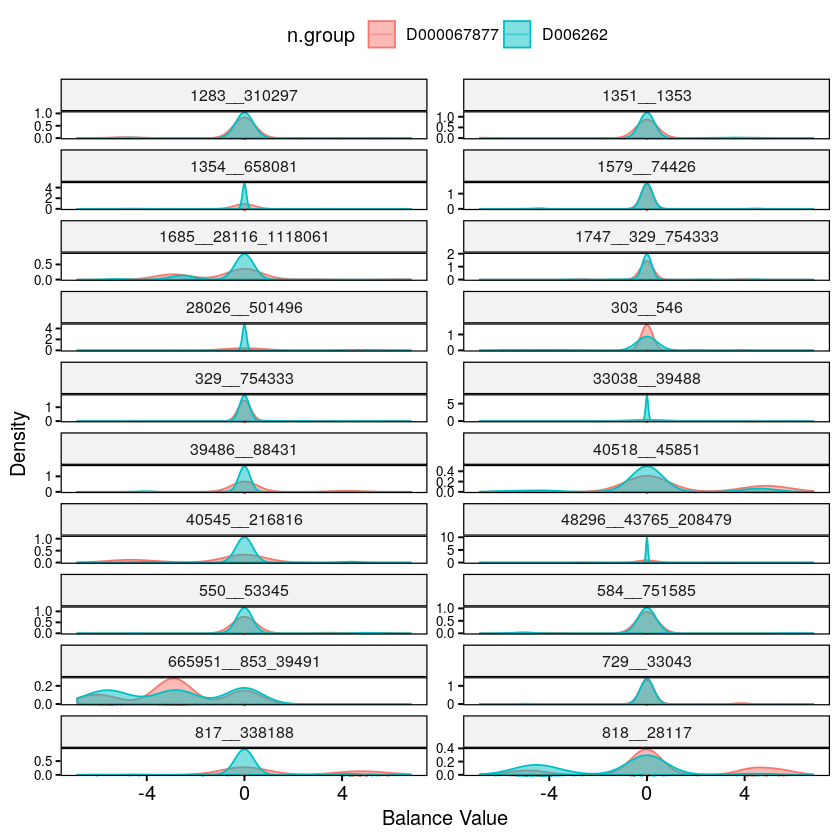

In [151]:
library(ggpubr)
p<- ggdensity(dt, 
              x = "SampleValue",
              rug = T, ncol=2,
              color = "n.group", fill = "n.group",
              palette = palette,
              facet.by = "BalanceID",  
              ylab="Density",
              xlab = "Balance Value",
              scales = "free_y",              
              short.panel.labs = T,) +
# theme(axis.ticks = element_blank(), axis.text.y = element_blank())
scale_y_continuous(breaks = scales::pretty_breaks(n = 2)) +
theme(axis.text.y = element_text(size=8))

ggsave(plot=p, filename=paste0(str_sub(lrg, 1,-4),'svg'),
       height = 10, units = "in",limitsize = FALSE)
p